In [49]:
import math
import random
import matplotlib.pyplot as plt

In [50]:
def read_sign_mnist_csv(filename, max_rows=None):
    X = []
    y = []
    with open(filename, 'r') as f:
        header = f.readline()
        for idx, line in enumerate(f):
            if max_rows and idx >= max_rows:
                break
            items = line.strip().split(',')
            label = int(items[0])
            pixels = [int(p)/255.0 for p in items[1:]]
            img = []
            for i in range(28):
                img.append([pixels[i*28+j] for j in range(28)])
            X.append([img])
            y.append(label)
    return X, y

In [51]:
def shuffle(X, y):
    idx = list(range(len(X)))
    random.shuffle(idx)
    return [X[i] for i in idx], [y[i] for i in idx]

def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

In [52]:
class Conv2D:
    def __init__(self, in_size, kernel_size, filters):
        self.kernel_size = kernel_size
        self.filters = filters
        self.kernels = [[[[
            random.uniform(-0.05, 0.05) for _ in range(kernel_size)
        ] for _ in range(kernel_size)] for _ in range(1)] for _ in range(filters)]
        self.bias = [random.uniform(-0.05, 0.05) for _ in range(filters)]

    def forward(self, x):
        h = len(x[0])
        w = len(x[0][0])
        out_size = h - self.kernel_size + 1
        out = [[[0 for _ in range(out_size)] for _ in range(out_size)] for _ in range(self.filters)]
        for f in range(self.filters):
            for i in range(out_size):
                for j in range(out_size):
                    s = 0
                    for ki in range(self.kernel_size):
                        for kj in range(self.kernel_size):
                            s += x[0][i+ki][j+kj] * self.kernels[f][0][ki][kj]
                    out[f][i][j] = s + self.bias[f]
        return out

In [53]:
class MaxPool2D:
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def forward(self, x):
        C = len(x)
        H = len(x[0])
        W = len(x[0][0])
        out_H = H // self.pool_size
        out_W = W // self.pool_size
        out = [[[0 for _ in range(out_W)] for _ in range(out_H)] for _ in range(C)]
        for c in range(C):
            for i in range(out_H):
                for j in range(out_W):
                    mx = -math.inf
                    for pi in range(self.pool_size):
                        for pj in range(self.pool_size):
                            mx = max(mx, x[c][i*self.pool_size+pi][j*self.pool_size+pj])
                    out[c][i][j] = mx
        return out

In [54]:
class Flatten:
    def forward(self, x):
        return [v for c in x for row in c for v in row]

In [55]:
class Dense:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weights = [[random.uniform(-0.05, 0.05) for _ in range(in_features)] for _ in range(out_features)]
        self.bias = [random.uniform(-0.05, 0.05) for _ in range(out_features)]
        self.last_input = None

    def forward(self, x):
        self.last_input = x
        return [sum([self.weights[i][j]*x[j] for j in range(self.in_features)]) + self.bias[i] for i in range(self.out_features)]

    def backward(self, grad_out, lr):
        grad_x = [0 for _ in range(self.in_features)]
        for i in range(self.out_features):
            for j in range(self.in_features):
                grad = grad_out[i]
                self.weights[i][j] -= lr * grad * self.last_input[j]
                grad_x[j] += grad * self.weights[i][j]
            self.bias[i] -= lr * grad_out[i]
        return grad_x

In [56]:
def relu(x):
    if isinstance(x[0], list):
        return [relu(sub) for sub in x]
    return [max(0, v) for v in x]

def relu_backward(grad_out, last_x):
    if isinstance(last_x[0], list):
        return [relu_backward(g, x) for g, x in zip(grad_out, last_x)]
    return [g if x > 0 else 0 for g, x in zip(grad_out, last_x)]

In [57]:
def softmax(x):
    m = max(x)
    exps = [math.exp(i-m) for i in x]
    sum_exps = sum(exps)
    return [e/sum_exps for e in exps]

def cross_entropy(pred, label):
    eps = 1e-10
    return -math.log(pred[label] + eps)

def cross_entropy_grad(pred, label):
    grad = [p for p in pred]
    grad[label] -= 1
    return grad

In [58]:
def get_flatten_size():
    size = 28
    size = (size - 3 + 1) // 2
    size = (size - 3 + 1) // 2
    size = (size - 3 + 1) // 2
    return size * size * 512

In [59]:
def plot_image(img, label=None, pred=None, idx=None):
    plt.imshow(img[0], cmap='gray')
    title = ""
    if label is not None: title += f"Label: {label} "
    if pred is not None: title += f"Pred: {pred}"
    if idx is not None: title = f"#{idx} " + title
    plt.title(title)
    plt.axis('off')

In [60]:
X_train, y_train = read_sign_mnist_csv('sign_mnist_train.csv', max_rows=30)
X_test, y_test = read_sign_mnist_csv('sign_mnist_test.csv', max_rows=10)
print("Train samples:", len(X_train), "Test samples:", len(X_test))

Train samples: 30 Test samples: 10


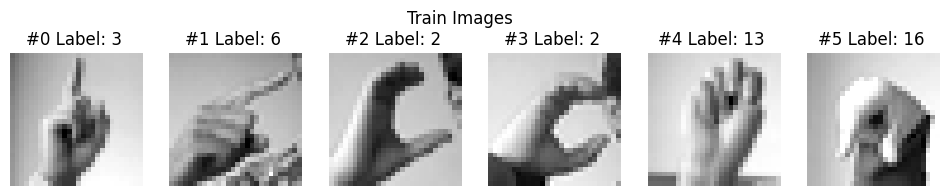

In [61]:
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plot_image(X_train[i], label=y_train[i], idx=i)
plt.suptitle("Train Images")
plt.show()

In [62]:
img_size = 28
num_classes = 25
epochs = 3
batch_size = 8
lr = 0.00005

In [63]:
conv1 = Conv2D(img_size, 3, 32)
pool1 = MaxPool2D(2)
conv2 = Conv2D(13, 3, 128)
pool2 = MaxPool2D(2)
conv3 = Conv2D(5, 3, 512)
pool3 = MaxPool2D(2)
flatten = Flatten()
flatten_size = get_flatten_size()
print("Flatten size:", flatten_size)

dense1 = Dense(flatten_size, 4096)
dense2 = Dense(4096, 1024)
dense3 = Dense(1024, 256)
dense_out = Dense(256, num_classes)

Flatten size: 512


In [64]:
history_loss, history_acc = [], []
for ep in range(epochs):
    X_train, y_train = shuffle(X_train, y_train)
    total_loss = 0
    correct = 0
    for Xb, yb in get_batches(X_train, y_train, batch_size):
        for xi, yi in zip(Xb, yb):
            # Forward through layer
            x = conv1.forward(xi)
            x = relu(x)
            x = pool1.forward(x)
            x = conv2.forward(x)
            x = relu(x)
            x = pool2.forward(x)
            x = conv3.forward(x)
            x = relu(x)
            x = pool3.forward(x)
            x = flatten.forward(x)
            x1 = dense1.forward(x)
            x1_relu = relu(x1)
            x2 = dense2.forward(x1_relu)
            x2_relu = relu(x2)
            x3 = dense3.forward(x2_relu)
            x3_relu = relu(x3)
            logits = dense_out.forward(x3_relu)
            probs = softmax(logits)
            loss = cross_entropy(probs, yi)
            total_loss += loss
            pred = probs.index(max(probs))
            if pred == yi:
                correct += 1

            # Backward each Dense/ReLU layer
            grad_logits = cross_entropy_grad(probs, yi)
            grad = dense_out.backward(grad_logits, lr)
            grad = relu_backward(grad, x3)
            grad = dense3.backward(grad, lr)
            grad = relu_backward(grad, x2)
            grad = dense2.backward(grad, lr)
            grad = relu_backward(grad, x1)
            grad = dense1.backward(grad, lr)
    avg_loss = total_loss / len(X_train)
    acc = correct / len(X_train)
    history_loss.append(avg_loss)
    history_acc.append(acc)
    print(f"Epoch {ep+1}, Loss: {avg_loss:.3f}, Acc: {acc:.3f}")

Epoch 1, Loss: 3.223, Acc: 0.033
Epoch 2, Loss: 3.223, Acc: 0.033
Epoch 3, Loss: 3.223, Acc: 0.033


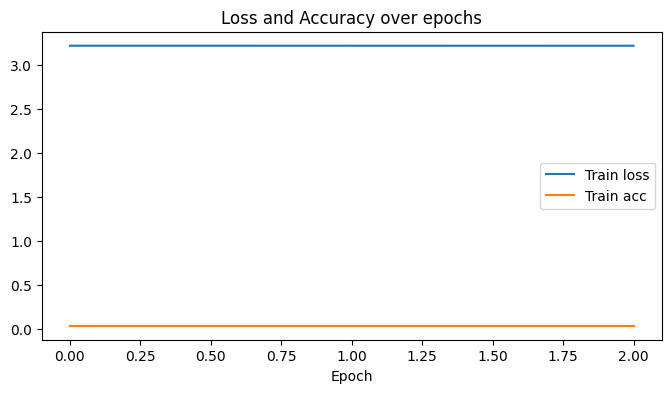

In [65]:
plt.figure(figsize=(8,4))
plt.plot(history_loss, label='Train loss')
plt.plot(history_acc, label='Train acc')
plt.legend()
plt.title("Loss and Accuracy over epochs")
plt.xlabel("Epoch")
plt.show()

In [66]:
correct_img_idx, wrong_img_idx = [], []
preds = []
print("\nTest prediction:")
for i in range(len(X_test)):
    x = conv1.forward(X_test[i])
    x = relu(x)
    x = pool1.forward(x)
    x = conv2.forward(x)
    x = relu(x)
    x = pool2.forward(x)
    x = conv3.forward(x)
    x = relu(x)
    x = pool3.forward(x)
    x = flatten.forward(x)
    x1 = dense1.forward(x)
    x1_relu = relu(x1)
    x2 = dense2.forward(x1_relu)
    x2_relu = relu(x2)
    x3 = dense3.forward(x2_relu)
    x3_relu = relu(x3)
    logits = dense_out.forward(x3_relu)
    probs = softmax(logits)
    pred = probs.index(max(probs))
    preds.append(pred)
    print(f"Sample {i}: Predict: {pred}, Label: {y_test[i]}")
    if pred == y_test[i]:
        correct_img_idx.append(i)
    else:
        wrong_img_idx.append(i)


Test prediction:
Sample 0: Predict: 10, Label: 6
Sample 1: Predict: 10, Label: 5
Sample 2: Predict: 10, Label: 10
Sample 3: Predict: 10, Label: 0
Sample 4: Predict: 10, Label: 3
Sample 5: Predict: 10, Label: 21
Sample 6: Predict: 10, Label: 10
Sample 7: Predict: 10, Label: 14
Sample 8: Predict: 10, Label: 3
Sample 9: Predict: 10, Label: 7


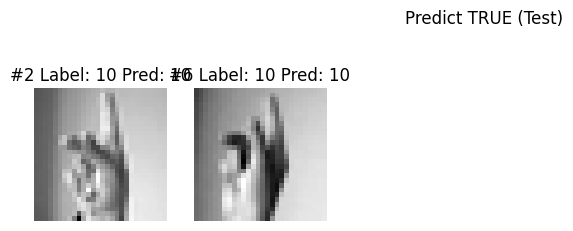

In [67]:
if correct_img_idx:
    plt.figure(figsize=(12, 3))
    for idx, i in enumerate(correct_img_idx[:6]):
        plt.subplot(1, 6, idx+1)

        plot_image(X_test[i], label=y_test[i], pred=preds[i], idx=i)
    plt.suptitle("Predict TRUE (Test)")
    plt.show()


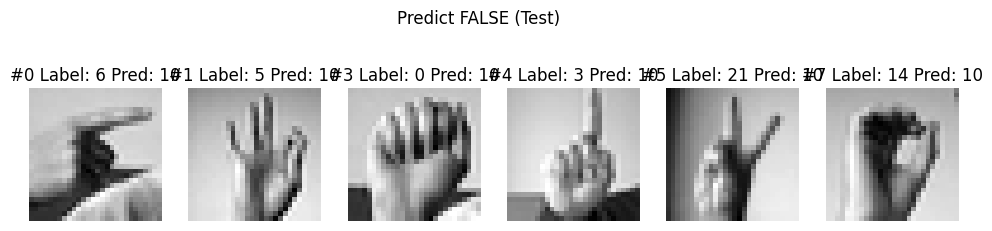

In [68]:
if wrong_img_idx:
    plt.figure(figsize=(12, 3))
    for idx, i in enumerate(wrong_img_idx[:6]):
        plt.subplot(1, 6, idx+1)
        plot_image(X_test[i], label=y_test[i], pred=preds[i], idx=i)
    plt.suptitle("Predict FALSE (Test)")
    plt.show()